# Bessel function
---
*Numerical Methods - homework 2,
Matic Šutar, ms4861@student.uni-lj.si*

In [1]:
import numpy as np
from scipy.special import j0
from matplotlib import pyplot as plt
from numpy.polynomial.legendre import leggauss

We will be computing the values of the Bessel function of the first kind defined as follows:

$J_0(x)=\frac{1}{\pi}\int_0^{\pi}\cos(x\cdot\sin(t))dt$

We will derive another definition of Bessel function to get an integrand with periodic zeros.\
This will hopefully translate to fewer function calls for the aproximation of the integral.

$J_0(x)$\
$=\frac{1}{\pi}\int_0^{\pi}\cos(x\cdot\sin(t))dt$\
$=\frac{2}{\pi}\int_0^{1}\frac{\cos(x\cdot u)}{\sqrt{1-u^2}}du \hspace{120pt} \text{(substition + function is symetrical over x=1)}$\
$=\cos(x) + \frac{2x}{\pi}\int_0^{1}\sin(x\cdot u)\sin^{-1}(u)du \hspace{30pt} \text{(per partes)}$

In [2]:
def integrand_0(t, x):
    return np.cos(x * np.sin(t))

def integrand_1(t, x):
    return np.sin(x*t)*np.arcsin(t)

We will use and compare different methods of integration.

In [3]:
def eval(f, x, w):
    integral = f(x)@w
    return integral

In [4]:
def numeric_integral(f, a, b, rule, n):
    """
    Compute the integral of f from a to b using some quadrature rule
    with n subintervals.

    Parameters:
    ----------
    f : callable
        The function to integrate
    a : float
        The lower limit of integration
    b : float
        The upper limit of integration
    rule : callable
        The quadrature rule to use
    n : int
        The number of subintervals to use

    Returns:
    -------
    float
        The value of the integral
    """
    x, w = rule(a, b, n)
    return eval(f, x, w)

## Simple methods (composite trapezodial and Simpson's)

In [5]:
def trapezoidal(a, b, n):
    """
    Compute the trapezoidal rule for the integral from a to b with n points.

    Parameters
    ----------
    a : float
        Lower bound of the integral.
    b : float
        Upper bound of the integral.
    n : int
        Number of points to use.

    Returns
    -------
    x : ndarray
        The points at which the function is evaluated.
    w : ndarray
        The weights for each point.
    """
    x = np.linspace(a, b, n)
    h = x[1] - x[0]
    w = np.zeros(n)
    w[0] = 0.5
    w[-1] = 0.5
    w[1:-1] = 1
    w *= h
    return x, w

In [6]:
def simpson(a,b,n):
    """
    Compute the nodes and weights for the Simpson quadrature rule. The number of nodes must be odd.

    Parameters:
    -----------
    a : float
        Lower integration limit.
    b : float
        Upper integration limit.
    n : int
        Number of nodes.

    Returns:
    -------
    x : numpy.ndarray
        Array with the integration nodes.
    w : numpy.ndarray
        Array with the integration weights.
    """

    x = np.linspace(a,b, n)
    h = x[1] - x[0]
    w = np.ones(n)
    w[1:-1:2] = 4
    w[2:-2:2] = 2
    w *= h/3
    return x, w

## Gauss-Legendre quadratures

In [7]:
def gauss_legendre(a, b, n, points=2):
    """
    Function to compute the integration points and weights using Gauss-Legendre quadrature
    over n subintervals between [a, b].

    Parameters:
    ----------
    a : float
        Lower bound of the integration interval.
    b : float
        Upper bound of the integration interval.
    n : int
        Number of subintervals.
    points : int
        Number of Gauss-Legendre points to use.

    Returns:
    -------
    x : numpy.ndarray
        Array with the integration nodes.
    w : numpy.ndarray
        Array with the integration weights.
    """
    # Define the subintervals
    x_subintervals = np.linspace(a, b, n+1)

    # Initialize arrays for all nodes (x) and weights (w)
    x = np.array([])
    w = np.array([])

    # Compute nodes and weights for the standard interval [-1, 1]
    xg, wg = leggauss(points)

    # Compute the Gauss-Legendre nodes and weights for each subinterval
    for i in range(n):
        # Subinterval bounds
        xi = x_subintervals[i]
        xi1 = x_subintervals[i+1]

        # Transform nodes to the current subinterval [xi, xi1]
        xg_transformed = 0.5 * (xi1 - xi) * xg + 0.5 * (xi1 + xi)
        wg_transformed = 0.5 * (xi1 - xi) * wg

        # Append the transformed nodes and weights to the global arrays
        x = np.concatenate((x, xg_transformed))
        w = np.concatenate((w, wg_transformed))

    return x, w

## Romberg's method

In [8]:
def romberg_integration(f, a, b, m):
    """
    Compute the integral of a function f over the interval [a, b] using Romberg's method.

    Parameters:
    f (function): The integrand function.
    a (float): Lower bound of the integration.
    b (float): Upper bound of the integration.
    m (int): Number of levels in Romberg's method.

    Returns:
    R (np.ndarray): The Romberg table (triangular matrix of estimates).
    result (float): The most accurate estimate of the integral.
    """

    # Initialize the Romberg table with zeros
    R = np.zeros((m, m))

    # Compute the initial trapezoidal rule estimates
    for k in range(m):
        n = 2 ** k
        h = (b - a) / n
        x = np.linspace(a, b, n + 1)
        R[k, 0] = (h / 2) * (f(a) + 2 * np.sum(f(x[1:-1])) + f(b))

        # Compute the Romberg extrapolations
        for j in range(1, k + 1):
            R[k, j] = (4 ** j * R[k, j - 1] - R[k - 1, j - 1]) / (4 ** j - 1)

    # The most accurate estimate is in the bottom right of the Romberg table
    result = R[m - 1, m - 1]
    return R, result

## Zeros of the second integrand and gauss-lobatto quadratures

In [9]:
def gauss_lobatto(a, b, n):
    if n == 3:
        x = np.array([-1, 0, 1])
        w = np.array([1/3, 4/3, 1/3])
    elif n == 4:
        x = np.array([-1, -1/np.sqrt(5), 1/np.sqrt(5), 1])
        w = np.array([1/6, 5/6, 5/6, 1/6])
    elif n == 5:
        x = np.array([-1, -np.sqrt(3/7), 0, np.sqrt(3/7), 1])
        w = np.array([1/10, 49/90, 32/45, 49/90, 1/10])
    else:
        raise ValueError('n must be 3, 4 or 5')
    x = (b-a)/2 * x + (a+b)/2
    w = (b-a)/2 * w
    return x, w

In [10]:
def bessel_zeros(x, f_n = 5, rule=gauss_lobatto):
    if x == 0:
        return 0.0
    period = np.pi / x
    n = int(1 // period)
    k = 1 % period
    if n < 1:
        xs, ws = rule(0, x, f_n)
        value = eval(lambda t: integrand_1(t, x), xs[1:], ws[1:])
        return np.cos(x) + 2*x/np.pi * value, len(xs) - 1
    zeros = np.linspace(0, n*period, n+1)
    value = 0
    n_calls = 0
    for i in range(n):
        xs, ws = rule(zeros[i], zeros[i+1], f_n)
        value += eval(lambda t: integrand_1(t, x), xs[1:-1], ws[1:-1])
        n_calls += len(xs) - 2
    if k != 0:
        xs, ws = rule(zeros[-1], 1, f_n)
        value += eval(lambda t: integrand_1(t, x), xs[1:], ws[1:])
        n_calls += len(xs) - 1
    value = np.cos(x) + 2*x/np.pi * value
    #n_calls = n * (len(xs)-2) + len(xs) - 1
    return value, n_calls

## Filon's method

If we wanted to have constant complexity in respect to $x$, we would need to use methods specifically tailored for integrating highly oscillating function.

One such method is filon's method of integration. The idea is to change the problem to the integration of a function of the form $g(x)\cdot f(x)$, where $g$ is slowly varying function and $f$ highly oscillating. Then $g$ is approximated using piece wise approximation with e.g. parabolas and the new integrand becomes much simpler and possibly analytically solvable.

The problem we didn't manage to solve when using this approach is the fact, that any integrands we derived had inappropriate behaviour for $x=1$. It was either a pole or the derivative was infinite. In both cases the $g$ function was badly approximated in this region with polynomials. This lead to the whole approximation being bad.

We tried to use a workaround, by using filon's method to integrate on interval $[0, 1-\epsilon]$, and some other method (e.g. composite trapezoidal rule) to integrate on interval $[1-\epsilon, 1]$ where $\epsilon$ is some small number. We can observe in the results, that the accuracy is not constant in respect to $x$, if we keep the same number of function evaluations. However, by decreasing the $\epsilon$ we can make it almost constant, up to some $x=C$, where $C$ is a large number.

In [ ]:
def int_x0sin(t, x):
    """
    Indefinite integral of sin(t*x) with respect to t.
    """
    return -(np.cos(t*x)) / x

def int_x1sin(t, x):
    """
    Indefinite integral of t*sin(t*x) with respect to t.
    """
    return (np.sin(t*x) - t*x*np.cos(t*x)) / x**2

def int_x2sin(t, x):
    """
    Indefinite integral of t^2*sin(t*x) with respect to t.
    """
    return ((2-t**2*x**2) * np.cos(t*x) + 2*t*x*np.sin(t*x)) / x**3

In [ ]:
def qinter_coef(f, x0, x1, x2):
    """
    Compute the coefficients of the quadratic interpolant of f at points x0, x1, x2.
    """
    y0, y1, y2 = f(x0), f(x1), f(x2)
    a = ((y0 - y1)*(x0 - x2) - ( y0 - y2)*(x0 - x1))/((x0**2 - x1**2)*(x0 - x2) - (x0**2 - x2**2)*(x0 - x1))
    b = ((y0 - y1) - a*(x0**2 - x1**2))/(x0 - x1)
    c = y0 - a*x0**2 - b*x0
    return a, b, c

def qinter_eval(a, b, c, x):
    """
    Evaluate the quadratic interpolant with coefficients a, b, c at point x.
    """
    return a*x**2 + b*x + c

In [ ]:
def qinter_int(a, b, c, x0, x1, x):
    """
    Compute the integral approximation of integrand a*t^2*sin(t*x) + b*t*sin(t*x) + c*sin(t*x)
    over the interval [x0, x1].
    """
    int0 = int_x0sin(x1, x) - int_x0sin(x0, x)
    int1 = int_x1sin(x1, x) - int_x1sin(x0, x)
    int2 = int_x2sin(x1, x) - int_x2sin(x0, x)
    return a*int2 + b*int1 + c*int0

In [81]:
# we use quad to compute the integral from [1-epsilon, 1] since it's better than using trapezoidal rule
from scipy.integrate import quad

def filon_j0(x, n, bp=0.99):
    i = np.linspace(0, bp, 2*n+1)
    x0 = i[:-1:2]
    x1 = i[1::2]
    x2 = i[2::2]
    a, b, c = qinter_coef(np.arcsin, x0, x1, x2)
    # plot the error of the interpolating polynomial
    #_, ax = plt.subplots(1, 1, figsize=(6, 3))
    #diff = np.arcsin(x2) - qinter_eval(a, b, c, x2)
    #diff = np.abs(diff)
    #print(diff)
    #ax.plot(x2, diff, label='error')
    #ax.set_xlabel('$x$')
    #ax.set_ylabel('Error')
    #ax.legend()
    #plt.show()

    value = np.sum(qinter_int(a, b, c, x0, x2, x))
    res = quad(integrand_1, bp, 1, args=(x), epsrel=1e-9, full_output=True)
    v, info = res[0], res[2]
    #v = numeric_integral(lambda t: integrand_1(t, x), bp, 1, trapezoidal, 300)
    value += v
    return np.cos(x) + 2*x/np.pi * value, 3*n + 6*n, info['neval']
    

## Comparisment of the methods

We will now compare the methods using a similar number of function calls (around 260). Gauss-Lobato method using zeros uses varying number of calls, while filon's method uses a higher number of calls.

In [64]:
def compute_values(interval, compute_gl=True):
    l = len(interval)
    values_j0 = j0(interval)
    values_nt = np.empty(l)
    values_ns = np.empty(l)
    values_ngl = np.empty(l)
    values_ro = np.empty(l)
    if compute_gl:
        values_gl = np.empty(l)
    else:
        values_gl = None
    values_fil = np.empty(l)
    n_calls = 0
    f_eval_other = 0
    f_eval_scipy = 0

    for idx, i in enumerate(interval):
        f = lambda t: integrand_0(t, i)
        
        # numerical integration using composite trapzoidal rule
        values_nt[idx] = numeric_integral(f, 0, np.pi, trapezoidal, 263) / np.pi

        # numerical integration using composite simpson rule
        values_ns[idx] = numeric_integral(f, 0, np.pi, simpson, 263) / np.pi

        # numerical integration using Gauss-Legendre quadrature
        gl = lambda a, b, n: gauss_legendre(a, b, n, 4) 
        values_ngl[idx] = numeric_integral(f, 0, np.pi, gl, 65) / np.pi # 4 * 65 = 260 -> 263

        # Romberg integration
        f = lambda t: np.cos(i * np.sin(t))
        m = 8
        R, result = romberg_integration(f, 0, np.pi, m)
        values_ro[idx] = result / np.pi

        # Gauss-Lobatto quadrature
        if compute_gl:
            values_gl[idx], n_calls = bessel_zeros(i, 5, gauss_lobatto)

        # Filon quadrature
        values_fil[idx], f_eval_other, f_eval_scipy = filon_j0(i, 100, 0.999)
    
    print(f'Number of function evaluations for Romberg: {2**(m)-1+m}')
    print(f'Number of function evaluations for Gauss-Lobatto: {n_calls}')
    print(f'Number of function evaluations for Filon: {f_eval_other} + {f_eval_scipy} = {f_eval_other + f_eval_scipy}')

    return values_j0, values_nt, values_ns, values_ngl, values_ro, values_gl, values_fil

In [63]:
def create_plots(interval, values_j0, values_nt, values_ns, values_ngl, values_ro, values_gl, values_fil):
    # plot function values
    _, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].plot(interval, values_nt, label='Composite Trapzoidal')
    ax[0].plot(interval, values_ns, label='Composite Simpson')
    ax[0].plot(interval, values_ngl, label='Gauss-Legendre')
    ax[0].plot(interval, values_ro, label='Romberg')
    if values_gl is not None:
        ax[0].plot(interval, values_gl, label='Gauss-Lobatto')
    ax[0].plot(interval, values_fil, label='Filon')
    ax[0].plot(interval, values_j0, label='j0', linewidth=5, alpha=0.3)
    ax[0].set_title('Function values')
    ax[0].legend()

    # plot error

    ax[1].plot(interval, np.abs(values_j0 - values_nt) / np.abs(values_j0), label='Composite Trapzoidal')
    ax[1].plot(interval, np.abs(values_j0 - values_ns) / np.abs(values_j0), label='Composite Simpson')
    ax[1].plot(interval, np.abs(values_j0 - values_ngl) / np.abs(values_j0), label='Gauss-Legendre')
    ax[1].plot(interval, np.abs(values_j0 - values_ro) / np.abs(values_j0), label='Romberg')
    if values_gl is not None:
        ax[1].plot(interval, np.abs(values_j0 - values_gl) / np.abs(values_j0), label='Gauss-Lobatto')
    ax[1].plot(interval, np.abs(values_j0 - values_fil) / np.abs(values_j0), label='Filon')
    ax[1].set_title('Errors')
    ax[1].set_yscale('log')
    ax[1].legend()
    plt.show()

/tmp/ipykernel_5669/2132554335.py:5: RuntimeWarning: invalid value encountered in arcsin
  return np.sin(x*t)*np.arcsin(t)


Number of function evaluations for Romberg: 263
Number of function evaluations for Gauss-Lobatto: 13
Number of function evaluations for Filon: 900 + 105 = 1005


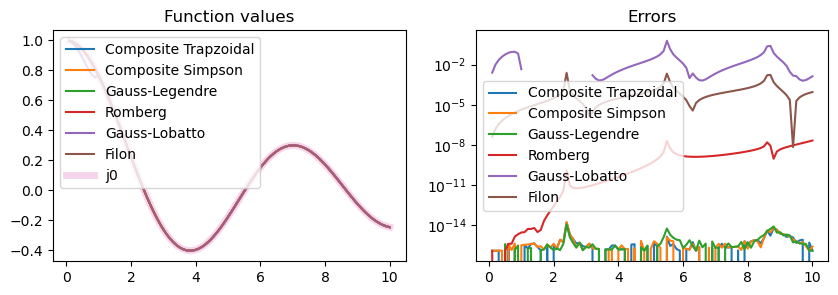

In [82]:
interval = np.linspace(0.1, 10, 100)
res = compute_values(interval)
create_plots(interval, *res)

Number of function evaluations for Romberg: 263
Number of function evaluations for Gauss-Lobatto: 214
Number of function evaluations for Filon: 900 + 21 = 921


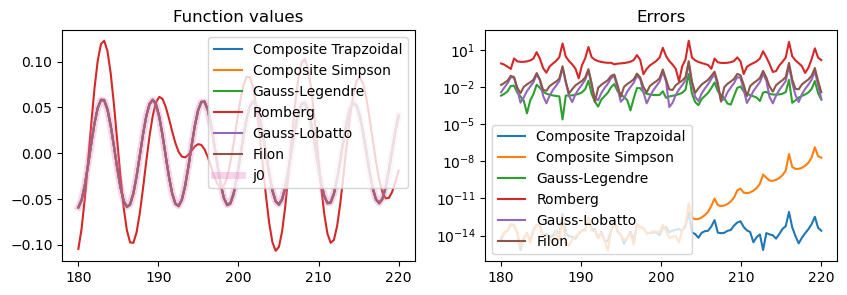

In [83]:
interval = np.linspace(180, 220, 100)
res = compute_values(interval)
create_plots(interval, *res)

Number of function evaluations for Romberg: 263
Number of function evaluations for Gauss-Lobatto: 403
Number of function evaluations for Filon: 900 + 105 = 1005


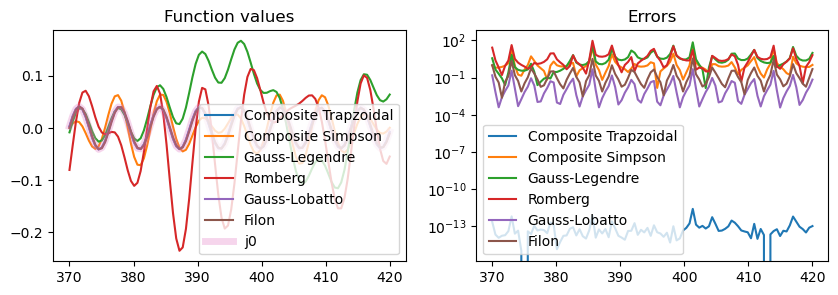

In [84]:
interval = np.linspace(370, 420, 100)
res = compute_values(interval)
create_plots(interval, *res)

Number of function evaluations for Romberg: 263
Number of function evaluations for Gauss-Lobatto: 709
Number of function evaluations for Filon: 900 + 189 = 1089


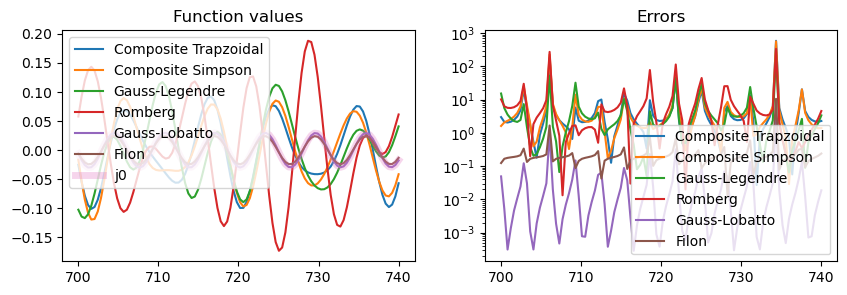

In [85]:
interval = np.linspace(700, 740, 100)
res = compute_values(interval)
create_plots(interval, *res)

Number of function evaluations for Romberg: 263
Number of function evaluations for Gauss-Lobatto: 997
Number of function evaluations for Filon: 900 + 21 = 921


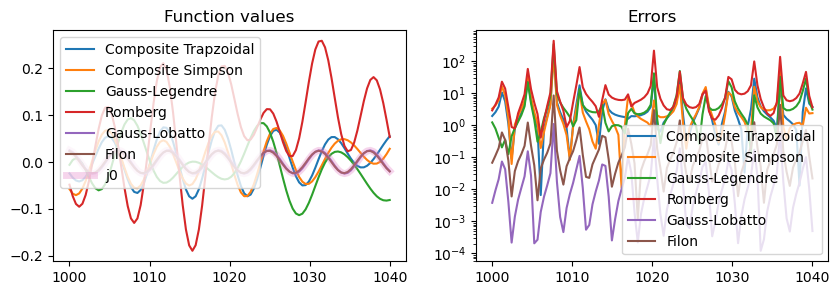

In [86]:
interval = np.linspace(1000, 1040, 100)
res = compute_values(interval)
create_plots(interval, *res)

Number of function evaluations for Romberg: 263
Number of function evaluations for Gauss-Lobatto: 95533
Number of function evaluations for Filon: 900 + 315 = 1215


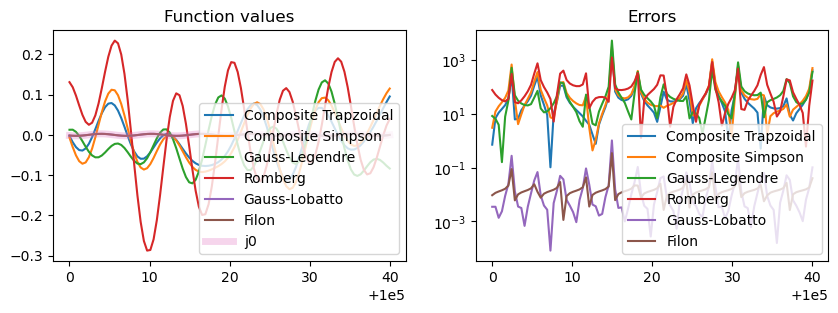

In [87]:
interval = np.linspace(100000, 100040, 100)
res = compute_values(interval, compute_gl=True)
create_plots(interval, *res)